In [1]:
import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [3]:
dataset_train = dsets.MNIST(root='./data/mnist', train=True, transform=transforms.ToTensor(), download=True)
dataset_test = dsets.MNIST(root='./data/mnist', train=False, transform=transforms.ToTensor())

In [5]:
num_train = int(len(dataset_train) * 0.9)  
num_val = len(dataset_train) - num_train

dataset_train, dataset_val = torch.utils.data.random_split(dataset_train, [num_train, num_val])

In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=64, shuffle=True)

In [11]:
dataset_train[0][0].shape

torch.Size([1, 28, 28])

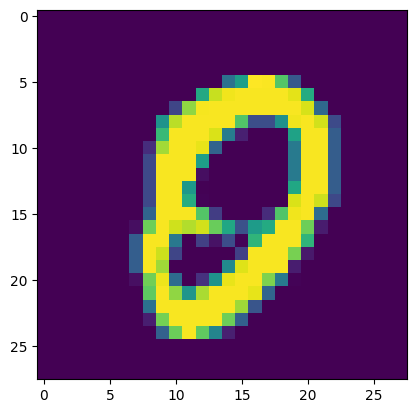

In [9]:
plt.imshow(dataset_train[0][0].numpy()[0,...])

In [49]:
class CronvNet(nn.Module):
    def __init__(self, input_dim=28, hidden_dim=128, classes=10):
        super(CronvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(input_dim // 4 * input_dim // 4 * 16, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = torch.flatten(self.dropout(x), 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [50]:
input_dim = 28
hidden_dim = 128
classes = 10

net = CronvNet(input_dim, hidden_dim, classes)

cost = torch.nn.NLLLoss()
optim = torch.optim.Adam(net.parameters(), lr=0.01)
epochs = 10
losses = []

for epoch in range(epochs):
    net.train()

    for x, y in train_loader:
        optim.zero_grad()
        pred = net(x)
        loss = cost(pred, y)
        losses.append(loss.item())
        loss.backward()
        optim.step()

    net.eval()
    with torch.no_grad():
        val_losses = []
        corrects = 0
        for x, y in val_loader:
            pred = net(x)
            _, pval = torch.max(pred, dim=1)
            corrects += (pval == y).sum().item()
            loss = cost(pred, y)
            val_losses.append(loss.item())

    acc = corrects / len(dataset_val)
    print(f'Epoch: {epoch+1}, 训练损失：{np.mean(losses)}, 校验损失：{np.mean(val_losses)}，校验准确率：{acc}')

Epoch: 1, 训练损失：0.3082832038883667, 校验损失：0.08555569858389332，校验准确率：0.9741666666666666
Epoch: 2, 训练损失：0.23386232374882618, 校验损失：0.08296436838250845，校验准确率：0.9758333333333333
Epoch: 3, 训练损失：0.2035943473270678, 校验损失：0.0690673557357823，校验准确率：0.9816666666666667
Epoch: 4, 训练损失：0.1868600501732402, 校验损失：0.06308764739933008，校验准确率：0.9825
Epoch: 5, 训练损失：0.1750594868659046, 校验损失：0.06330328370305768，校验准确率：0.9828333333333333
Epoch: 6, 训练损失：0.16693639522473552, 校验损失：0.05800119940032984，校验准确率：0.9838333333333333
Epoch: 7, 训练损失：0.1607621435744224, 校验损失：0.05791615492892154，校验准确率：0.984
Epoch: 8, 训练损失：0.15568322871183196, 校验损失：0.0612741218498373，校验准确率：0.9825
Epoch: 9, 训练损失：0.1523629467223219, 校验损失：0.07572858099964389，校验准确率：0.9826666666666667
Epoch: 10, 训练损失：0.14915280028248273, 校验损失：0.056503214187266185，校验准确率：0.9861666666666666


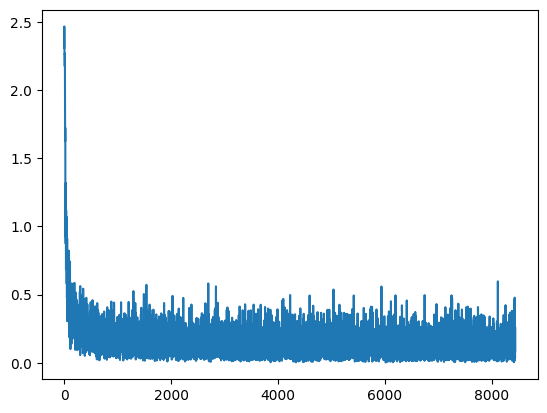

In [51]:
plt.plot(losses)